# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import pdb
import random
import os
import json

## Construcción del conjunto de datos

In [0]:
raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

### Elegimos 100 categorias al azar y las descargamos

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []
max_num_categories = 5

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [6]:
!mkdir quick_draw_data
os.chdir("/content/quick_draw_data")

mkdir: cannot create directory ‘quick_draw_data’: File exists


In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)
  os.system("mkdir train/" + aux)
  os.system("mkdir test/" + aux)

In [8]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/toilet.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/bench.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/trombone.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/star.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/bicycle.ndjson


In [9]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if cat not in categories:
    print("falta " + cat)

219


In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= 2
      inkarray[idx][1][idy] /= 2
      inkarray[idx][1][idy] = 127 - inkarray[idx][1][idy]   # flip en eje y
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 classnames,
                 output_shards=10,
                 offset=0):
  """Convert training data from ndjson files into tf.Example in tf.Record.
  Args:
   trainingdata_dir: path to the directory containin the training data.
     The training data is stored in that directory as ndjson files.
   observations_per_class: the number of items to load per class.
   output_file: path where to write the output.
   classnames: array with classnames - is auto created if not passed in.
   output_shards: the number of shards to write the output in.
   offset: the number of items to skip at the beginning of each file.
  Returns:
    classnames: the class names as strings. classnames[classes[i]] is the
      textual representation of the class of the i-th data point.
  """
  
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue   
   
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break
          
  reading_order = range(len(file_handles)) * observations_per_class
  random.shuffle(reading_order)

  my_dpi = 96.0
  plt.figure(figsize=(128/my_dpi, 128/my_dpi), dpi=my_dpi)
  
  for number in reading_order:
    line = file_handles[number].readline()
    ink = None
    while ink is None:
      ink, class_name = parse_line(line)
      if ink is None:
        print ("Couldn't parse ink from '" + line + "'.")
        
    for stroke in ink:
      plt.plot(stroke[0], stroke[1], 'k')
    
    plt.savefig(class_name + '/' + str(number) + '.png', dpi=my_dpi)
    plt.clf()

In [0]:
plt.ioff()

train_samples_per_cat = 5

convert_data(".",
             train_samples_per_cat,
             "train/",
             [])    

In [55]:
!ls 

ambulance	  guitar		     rain.ndjson
ambulance.ndjson  guitar.ndjson		     rhinoceros
angel		  hand			     rhinoceros.ndjson
angel.ndjson	  hand.ndjson		     saxophone
apple		  harp			     saxophone.ndjson
apple.ndjson	  harp.ndjson		     school
ball		  hedgehog		     scorpion
barn		  hedgehog.ndjson	     scorpion.ndjson
barn.ndjson	  helmet		     shovel
baseball	  hospital		     shovel.ndjson
bat		  hospital.ndjson	     sign
bathtub		  hourglass		     sink
bathtub.ndjson	  hourglass.ndjson_.gstmp    sink.ndjson
bench		  house			     skull
bench.ndjson	  house.ndjson		     skull.ndjson
bicycle		  house plant		     skyscraper
bicycle.ndjson	  house plant.ndjson_.gstmp  skyscraper.ndjson
blueberry	  jacket		     smiley
blueberry.ndjson  jacket.ndjson		     snake
book		  key			     snake.ndjson
book.ndjson	  key.ndjson		     snorkel
bottle		  knife			     snorkel.ndjson
bowtie		  knife.ndjson		     soccer
bowtie.ndjson	  lantern		     speedboat
bracelet	  lantern.ndjson	     speedboat.ndj

In [83]:
!ls wheel

84.svg	90.png	90.svg


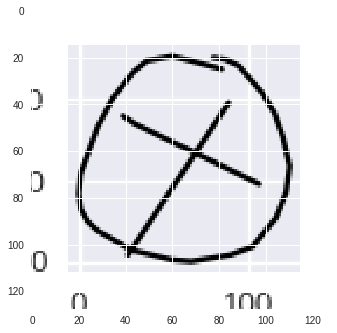

In [84]:
figure = plt.imread("wheel/90.png")
plt.imshow(figure)